# 交通號誌識別
## 資料簡介
* 參考做法來源: https://sites.coecis.cornell.edu/chaowang/2017/02/10/158/
* 原始資料來源: 德國交通號誌識別 http://benchmark.ini.rub.de/?section=gtsrb&subsection=news


## 分析摘要
* Step1:讀取與觀察資料
* Step2:資料可視化分析---EDA
* Step3:資料預/前處理
* Step4:建立Model
* Step5:開始訓練model
* Step6:測試Model

In [1]:
#import important packages/libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random #隨機處理資料的模組，詳細說明 http://ot-note.logdown.com/posts/1398257/python-random-quick-note
import csv #資料格式csv的模組
from sklearn.utils import shuffle #打散資料的模組
from skimage import transform as transf #轉換資料格式的模組
from sklearn.model_selection import train_test_split 
import cv2 #影像視覺處理的模組
from prettytable import PrettyTable #呈現表格式資料的模組


## Step1 : 讀取與觀察資料

In [2]:
#Step1:讀資料
# Load pickled data 讀取資料集的pickle檔
import pickle #壓縮和解壓縮檔案的套件

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# 查看train data的數量
n_train = X_train.shape[0]

# 查看test data的數量
n_test = X_test.shape[0]

# 查看train data的資料型態shape
image_shape =  X_train[0].shape

# 查看test data有幾類
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Step2:資料可視化分析---EDA

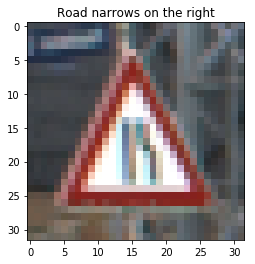

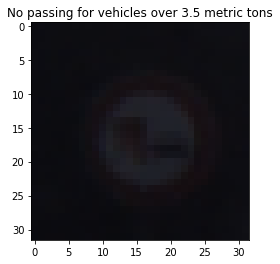

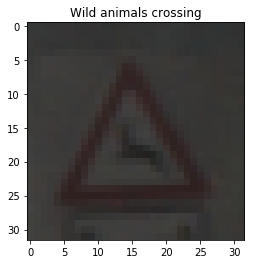

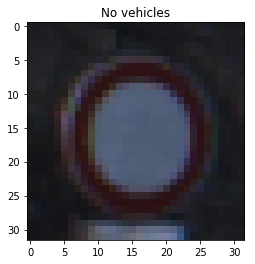

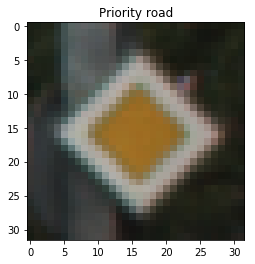

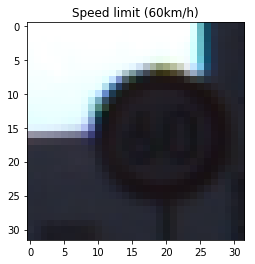

Text(0.5,1,'Histogram of 43 classes in the training dataset')

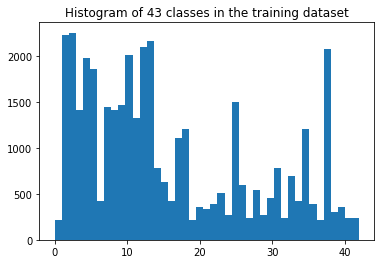

In [4]:
#進行資料可視化
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#定義讀取類別資料
def load_label_file(file):
    lines = open(file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

#讀取交通號誌名稱對照的csv檔
label_descriptions = load_label_file("signnames.csv")

#從train data任意選取6個樣本並且畫出來

n_samples = 6
isample = np.random.randint(0, n_train, n_samples)
sample_imgs = X_train[isample]
sample_labels = list(map(label_descriptions.get, y_train[isample]))

#顯示6張圖片和對照的名稱
for img, label in zip(sample_imgs, sample_labels):
    plt.imshow(img)
    plt.title(label)
    plt.show()
    

#畫出類別資料的長條圖，查看43類中的各資料數量
plt.hist(y_train, bins=43)
plt.title("Histogram of 43 classes in the training dataset")

In [5]:
#將交通號誌名稱的csv檔列出來，方便對照查看
label_descriptions = pd.read_csv("signnames.csv")
print(label_descriptions)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

## Step3:資料預/前處理

In [6]:
# we first shuffle the data 先將data隨機打散，訓練出來的model相對會比較好。因為原本資料是有序的排列。
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

#安裝opencv套件進行影像處理
import cv2
#定義將圖片從RGB轉成灰階的函式。原則為凸顯影像特徵，同時降低影像處理的資料運算量。
def RGB_2_GRAY(image_array):
    return cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

#定義將圖片進行Normalization標準化的函式
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255.
    return a + (image_data - greyscale_min)*(b - a)/( greyscale_max - greyscale_min ) 

#定義資料預處理的函式，將原圖RGB格式轉成灰階格式。
def preprocess(data):
    gray_images = []
    for image in data:
        gray = RGB_2_GRAY(image)
        gray_images.append(gray)
        
    return np.array(gray_images)

In [7]:
#開始進行資料預處理
from numpy import newaxis
print('Preprocessing training data...')

# Iterate through grayscale 將train data轉換成灰階
X_train_gray = preprocess(X_train)
X_train_gray = X_train_gray[..., newaxis] 

X_test_gray = preprocess(X_test)
X_test_gray = X_test_gray[..., newaxis]

# Normalization 將灰階化的train data標準化
X_train_pro = normalize_grayscale(X_train_gray)
X_test_pro = normalize_grayscale(X_test_gray)

#print the shape of the new image 顯示處理過的新圖片的型態
print("Training set Image data shape =", X_train_gray.shape)
print("Testing set Image data shape =", X_test_gray.shape)

print('All figures are in normalized gray-scale.')

Preprocessing training data...
Training set Image data shape = (39209, 32, 32, 1)
Testing set Image data shape = (12630, 32, 32, 1)
All figures are in normalized gray-scale.


In [8]:
### Generate data additional data (OPTIONAL!) 產生額外的train data
#因為各類別的資料量多寡不一，為了提升模型的成效，可用生成資料的套件，將數量過少的類別中的資料，增加到一定數量，以利訓練。

### and split the data into training/validation/testing sets here.
'''
pics_in_class = np.bincount(y_train)
median_pics = int(np.median(pics_in_class))
lower_bound = median_pics
'''

from scipy import ndimage
import random

imag_class = np.bincount(y_train)
lower_bound = 1000


# Iterate through each class
for i in range(len(imag_class)):
    
    # Check if less data than the mean 少於100數量的類別，將資料生成至滿足數量100
    if imag_class[i] < lower_bound:
        
        # Count how many additional pictures we want計算我們需要的額外圖片數量
        num_new = lower_bound - imag_class[i]
        picture = np.where(y_train == i)
        more_X = []
        more_y = []
        
        # Make the number of additional pictures needed to arrive at the mean產生達到平均值數量的圖片
        for num in range(num_new):
            
            # Rotate images and append new ones to more_X, append the class to more_y 以將圖片旋轉的方式生成新的圖片
            more_X.append(ndimage.rotate(X_train_pro[picture][random.randint(0,imag_class[i] - 1)],\
                                         random.uniform(-15,15), reshape=False))
            more_y.append(i)
        
        # Append the pictures generated for each class back to the original data
        X_train_pro = np.append(X_train_pro, np.array(more_X), axis=0)
        y_train = np.append(y_train, np.array(more_y), axis=0)
        
print('Additional data generated. Any classes lacking data now have', lower_bound, 'pictures.')
print("Number of training examples =", X_train_pro.shape)


Additional data generated. Any classes lacking data now have 1000 pictures.
Number of training examples = (54710, 32, 32, 1)


Text(0.5,1,'Histogram of 43 classes in the enlarged training dataset')

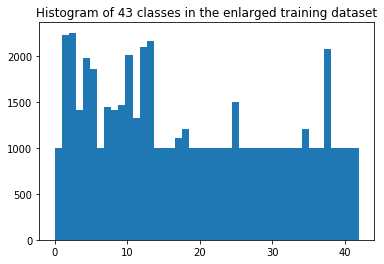

In [9]:
#顯示新增圖片後的長條圖
plt.hist(y_train, bins=43)
plt.title("Histogram of 43 classes in the enlarged training dataset")

In [10]:
### Create the Validation Set - 20% of the training set
#將training資料中的20%切出來作為validation的資料
from sklearn.cross_validation import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train_pro, y_train, test_size=0.2, random_state=42)

print('Size of X_train = ', X_train.shape)
print('Size of X_valid = ', X_validation.shape)
print('Size of y_train = ', y_train.shape)
print('Size of y_valid = ', y_validation.shape)

Size of X_train =  (43768, 32, 32, 1)
Size of X_valid =  (10942, 32, 32, 1)
Size of y_train =  (43768,)
Size of y_valid =  (10942,)


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
from keras.utils import np_utils
y_train_OH = np_utils.to_categorical(y_train,43)
y_test_OH = np_utils.to_categorical(y_test,43)

/home/user/jupyter/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Step4 : 建立Model

In [12]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.utils import np_utils

# 建立簡單的線性執行的模型
model = Sequential()
# 建立卷積層，filter=16,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(32,32,1), 
                 activation='relu'))

# 建立池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))

# 建立卷積層，filter=32,即 output size, Kernal Size: 3x3, activation function 採用 relu
model.add(Conv2D(filters=36,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu'))

# 建立池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
model.add(Flatten())

# 全連接層: 128個output
model.add(Dense(128, activation='relu'))

## Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.5
#model.add(Dropout(0.5))

# 使用 softmax activation function，將結果分類 (分成43類)
model.add(Dense(43, activation='softmax'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [13]:
print(model.summary()) #模型架構可視化

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        5220      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               295040    
_________________________________________________________________
dense_2 (Dense)              (None, 43)                5547      
Total para

## Step:5開始訓練model

In [14]:
model.fit(X_train, y_train_OH, validation_split=0.2, epochs=100, batch_size=150, verbose=2)

Train on 35014 samples, validate on 8754 samples
Epoch 1/100
 - 3s - loss: 2.5470 - acc: 0.3328 - val_loss: 1.2810 - val_acc: 0.6422
Epoch 2/100
 - 2s - loss: 0.8228 - acc: 0.7793 - val_loss: 0.5547 - val_acc: 0.8615
Epoch 3/100
 - 1s - loss: 0.4438 - acc: 0.8849 - val_loss: 0.3913 - val_acc: 0.9006
Epoch 4/100
 - 1s - loss: 0.2943 - acc: 0.9251 - val_loss: 0.2783 - val_acc: 0.9318
Epoch 5/100
 - 1s - loss: 0.2155 - acc: 0.9456 - val_loss: 0.2396 - val_acc: 0.9387
Epoch 6/100
 - 1s - loss: 0.1688 - acc: 0.9574 - val_loss: 0.2211 - val_acc: 0.9388
Epoch 7/100
 - 1s - loss: 0.1311 - acc: 0.9676 - val_loss: 0.1661 - val_acc: 0.9577
Epoch 8/100
 - 1s - loss: 0.1083 - acc: 0.9735 - val_loss: 0.1443 - val_acc: 0.9648
Epoch 9/100
 - 1s - loss: 0.0908 - acc: 0.9776 - val_loss: 0.1540 - val_acc: 0.9641
Epoch 10/100
 - 1s - loss: 0.0741 - acc: 0.9818 - val_loss: 0.1182 - val_acc: 0.9725
Epoch 11/100
 - 1s - loss: 0.0649 - acc: 0.9841 - val_loss: 0.1265 - val_acc: 0.9690
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 1s - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0542 - val_acc: 0.9925
Epoch 98/100
 - 1s - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0542 - val_acc: 0.9921
Epoch 99/100
 - 1s - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0547 - val_acc: 0.9922
Epoch 100/100
 - 1s - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0546 - val_acc: 0.9923


In [15]:
#檢視模型績效
scores = model.evaluate(X_test_gray, y_test_OH)  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))  

12630/12630 [==============================] - 0s 34us/step
	[Info] Accuracy of testing data = 88.6%


* epochs=40, acc = 87%
* epochs=100, acc = 89.5%
* epochs=200, acc = 90.5%

In [16]:
# 模型結構存檔
from keras.models import model_from_json
json_string = model.to_json()
with open("model.config", "w") as text_file:
    text_file.write(json_string)

# 模型訓練結果存檔
model.save_weights("model_trafficsign.weight")

# 同時儲存結構與權重
from keras.models import load_model
model.save('model_trafficsign.h5')  # creates a HDF5 file 'model.h5'

## Step6 : 測試模型

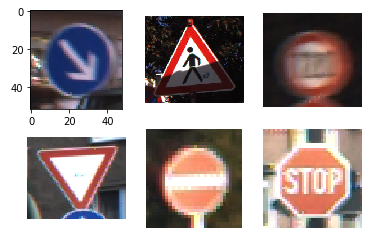

In [17]:
#隨機找6張圖做測試
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image1=mpimg.imread('./GTSRB/Final_Test/test_Images/00002.ppm')
plt.subplot(2,3,1)
#plt.axis('off')
plt.imshow(image1)

image2=mpimg.imread('./GTSRB/Final_Test/test_Images/07225.ppm')
plt.subplot(2,3,2)
plt.axis('off')
plt.imshow(image2)

image3=mpimg.imread('./GTSRB/Final_Test/test_Images/04225.ppm')
plt.subplot(2,3,3)
plt.axis('off')
plt.imshow(image3)

image4=mpimg.imread('./GTSRB/Final_Test/test_Images/12025.ppm')
plt.subplot(2,3,4)
plt.axis('off')
plt.imshow(image4)

image5=mpimg.imread('./GTSRB/Final_Test/test_Images/08225.ppm')
plt.subplot(2,3,5)
plt.axis('off')
plt.imshow(image5)

image6=mpimg.imread('./GTSRB/Final_Test/test_Images/10225.ppm')
plt.subplot(2,3,6)
plt.axis('off')
plt.imshow(image6)

true_label=[38,27,8,13,17,14]

image1 = cv2.resize(image1, (32, 32)) #true label_38:Keep right
image2= cv2.resize(image2 ,(32, 32)) #true label_27:Pedestrians
image3= cv2.resize(image3,(32, 32)) #true label_8:Speed limit 120km/h
image4=cv2.resize(image4,(32, 32)) #true label_13:Yield
image5=cv2.resize(image5,(32, 32)) #true label_17:No entry
image6=cv2.resize(image6,(32, 32)) #true label_14:Stop

In [18]:
### Run the predictions here.進行預測

# Make into numpy array for processing 將圖片轉乘array的型態
test_figs_data = np.array([image1,image2,image3,image4,image5,image6])
#test_figs_data = np.array([image1,image2])

# First, double-check the image shape to make sure it matches the original data's 32x32x3 size
#確認原始資料的sahpe是否正確
print(test_figs_data.shape)

(6, 32, 32, 3)


In [19]:
print('Preprocessing additional pictures...')

# Iterate through grayscale將test data轉成灰階
test_figs_data = preprocess(test_figs_data)
test_figs_data = test_figs_data[..., newaxis]

# Normalize 將灰階化的的test data進行normalize
test_figs_data = normalize_grayscale(test_figs_data) 

print('Finished preprocessing additional pictures.')

# Double-check that the image is changed to depth of 1
#再次確認test data的影像深度為1通道
new_image_shape = test_figs_data.shape
print("Processed additional pictures shape =", new_image_shape)

Preprocessing additional pictures...
Finished preprocessing additional pictures.
Processed additional pictures shape = (6, 32, 32, 1)


In [20]:
# Run rhw predictions
predictions = model.predict_classes(test_figs_data)
for i in range(len(test_figs_data)):
    print('Image', i, 'prediction:',  predictions[i], ', the true label is', true_label[i],'.')

Image 0 prediction: 38 , the true label is 38 .
Image 1 prediction: 11 , the true label is 27 .
Image 2 prediction: 8 , the true label is 8 .
Image 3 prediction: 13 , the true label is 13 .
Image 4 prediction: 17 , the true label is 17 .
Image 5 prediction: 14 , the true label is 14 .


In [21]:
print(label_descriptions)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

結論 : 訓練完的模型準確率為90%，6張圖中，猜錯1張。因此可以以此架構調整參數，或者用其他模型的架構來提升準確率。